# Visualisierung eines Noise2Void-Runs

In diesem Notebook gibst du **einmalig** den Pfad zu deinem gespeicherten Run-Ordner an.  
Dann werden daraus automatisch geladen:
- die `config.py` (aus `used_source`),  
- dein U-Net-Modell mit dem Checkpoint `best.pt`,  
- Trainings- und Validierungs-Datasets,  
- und es werden exemplarisch je drei Beispiele aus Training und Validation geplottet.

# Parameter setzen:

In [1]:
import os
import sys

# — Stelle hier deinen Run-Ordner ein (z.B. …/trained_models/First_Test) —
run_dir = "../trained_models/Tumors_oversampled_xyzfT_4"    #_3Layers_ynetRank3"  # <-- anpassen

# GPU wählen
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # or whichever GPU you want

# Andere parameter automatisch laden

In [2]:
# ── Zelle 2: Run-Config & used_source in sys.path einfügen ──

import os
import sys
import importlib.util

# 1) Absoluter Pfad zum Run-Verzeichnis (aus Zelle 1)
run_dir = os.path.abspath(run_dir)

# 2) Pfad zum used_source-Snapshot
USED_SRC = os.path.join(run_dir, "used_source")

# 3) Ganz vorne in sys.path einfügen, damit alle Imports daraus gezogen werden
if USED_SRC not in sys.path:
    sys.path.insert(0, USED_SRC)

# (Optional) Projekt-Root als Fallback auf Position 1
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(1, PROJECT_ROOT)

# Debug: sys.path prüfen
print("⤷ sys.path[0:2] =", sys.path[:2])

# 4) Pfad zur Config im used_source-Ordner
config_path = os.path.join(USED_SRC, "config.py")

# 5) Dynamisch als Modul importieren
spec = importlib.util.spec_from_file_location("run_config", config_path)
run_config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(run_config)

# 6) Absoluten Pfad für checkpoint_dir anpassen (falls relativ)
if not os.path.isabs(run_config.checkpoint_dir):
    run_config.checkpoint_dir = os.path.join(PROJECT_ROOT, run_config.checkpoint_dir)

# 7) Werte ausgeben
print(f"RUN_NAME           = {run_config.RUN_NAME}")
print(f"Checkpoint-Ordner  = {run_config.checkpoint_dir}")


⤷ sys.path[0:2] = ['/workspace/Deuterium_Denosing/trained_models/Tumors_oversampled_xyzfT_4/used_source', '/workspace/Deuterium_Denosing']
RUN_NAME           = Tumors_oversampled_xyzfT_4
Checkpoint-Ordner  = /workspace/Deuterium_Denosing/trained_models/Tumors_oversampled_xyzfT_4/checkpoints


# Bibliotheken und Geräte

# Model laden

In [3]:
# --- Cell A: Device & Model --------------------------------------------------
import torch, os

# Device wählen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Verwendetes Device:", device)

# Modellklasse & Checkpoint-Name je nach TRAIN_METHOD
tm = run_config.TRAIN_METHOD.lower()
ud = run_config.UNET_DIM.lower()

if tm == "ynet_n2v":
    assert ud == "2d", "Y-Net ist nur für 2-D verfügbar"
    from models.ynet2d import YNet2D as NetClass
    ckpt_name = "best_ynet.pt"
    model = NetClass(
        in_ch_noisy  = run_config.in_channels_noisy,
        in_ch_lr     = run_config.in_channels_lr,
        out_channels = run_config.out_channels,
        features     = run_config.features
    ).to(device)

elif tm == "sup_lowrank":
    # Unser neues supervised Low-Rank U-Net
    assert ud == "2d", "Supervised LowRank U-Net wurde nur für 2-D implementiert"
    from models.unet2d import UNet2D as NetClass
    ckpt_name = "best_unet_lowrank.pt"
    model = NetClass(
        in_channels  = run_config.in_channels,    # typischerweise 2 (real+imag)
        out_channels = run_config.out_channels,   # ebenfalls 2
        features     = run_config.features
    ).to(device)

else:
    # klassischer Noise2Void-U-Net (n2v oder n2s)
    if ud == "2d":
        from models.unet2d import UNet2D as NetClass
        ckpt_name = "last.pt"
    else:  # ud == "3d"
        from models.unet3d import UNet3D as NetClass
        ckpt_name = "last3d.pt"
        features = run_config.features_3d  # ← hier die Änderung
    model = NetClass(
        in_channels  = run_config.in_channels,
        out_channels = run_config.out_channels,
        features     = run_config.features
    ).to(device)

# --- Checkpoint laden --------------------------------------------------------
ckpt_path = os.path.join(run_config.checkpoint_dir, ckpt_name)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print(f"✓ Modell geladen: {run_config.TRAIN_METHOD.upper()}-{run_config.UNET_DIM}  "
      f"({ckpt_name},  Epoch {ckpt.get('epoch','?')})")

Verwendetes Device: cuda
✓ Modell geladen: N2V-3d  (last3d.pt,  Epoch 500)


# Datasets & DataLoader

In [4]:
# ── Cell B + C: End-to-End-Inference & Post-Processing ──────────────────────
import numpy as np, torch, os
from itertools import product
from math import prod
from data.data_utils import load_and_preprocess_data, low_rank

# ---------------------------------------------------------------------------#
# 1) Validation-Daten laden
# ---------------------------------------------------------------------------#
data_val = load_and_preprocess_data(
    folder_names = ['Tumor_2_normalized'],#run_config.val_data ,#run_config.val_data, ['P07']
    base_path    = os.path.join(PROJECT_ROOT, "datasets"),
    fourier_axes = run_config.fourier_transform_axes
)

if run_config.TRAIN_METHOD == "ynet" or "ynet_n2v":
    lowrank_val = low_rank(data_val.copy(), rank=run_config.lowrank_rank)

# ---------------------------------------------------------------------------#
# 2) Achsen-Definition
# ---------------------------------------------------------------------------#
spatial_axes = (run_config.image_axes if run_config.UNET_DIM == "2d"
                else run_config.volume_axes)            # (len==2) oder (len==3)
all_axes     = list(range(data_val.ndim))
other_axes   = [ax for ax in all_axes if ax not in spatial_axes]
ranges       = [range(data_val.shape[ax]) for ax in other_axes]

print(f"Spatial axes: {spatial_axes} | Other axes: {other_axes} "
      f"→ geplante Vorwärtspässe: {prod(len(r) for r in ranges)}")

# ---------------------------------------------------------------------------#
# 3) Output-Array anlegen
# ---------------------------------------------------------------------------#
out_data = np.zeros_like(data_val, dtype=np.complex64)

# ---------------------------------------------------------------------------#
# 4) Hilfs-Funktion
# ---------------------------------------------------------------------------#
def to_tensor(arr):          # arr shape (2,*spatial)
    return torch.from_numpy(arr)[None].to(device)

# ---------------------------------------------------------------------------#
# 5) Inference-Loop
# ---------------------------------------------------------------------------#
model.eval()
with torch.no_grad():

    if run_config.UNET_DIM.lower() == "3d":
            # ─────────────────────────────── 3-D: drei Ansichten mitteln ───────────────────────────────
            axis_triplets = [(0, 3, 4), (1, 3, 4), (2,3,4)]   # x,f,T  | y,f,T | z,f,T
            out_sum  = np.zeros_like(data_val, dtype=np.complex64)
            vote_cnt = np.zeros_like(data_val, dtype=np.uint8)

            for spatial_axes in axis_triplets:
                all_axes   = list(range(data_val.ndim))
                other_axes = [ax for ax in all_axes if ax not in spatial_axes]
                ranges     = [range(data_val.shape[ax]) for ax in other_axes]

                for idx in product(*ranges):
                    slicer = [slice(None) if ax in spatial_axes
                            else idx[other_axes.index(ax)]
                            for ax in all_axes]

                    spec = data_val[tuple(slicer)]                  # (spatial,F,T) komplex
                    img  = np.stack([spec.real, spec.imag], axis=0).astype(np.float32)
                    pred = model(to_tensor(img)).squeeze(0).cpu().numpy()

                    den = pred[0] + 1j * pred[1]
                    out_sum [tuple(slicer)] += den
                    vote_cnt[tuple(slicer)] += 1

            out_data = out_sum / np.where(vote_cnt == 0, 1, vote_cnt)
            print("✓ 3-D-Inference für alle drei Ansichten abgeschlossen und gemittelt")

    else:
        # ─────────────────────────────── 2-D: unverändert ───────────────────────────────
        spatial_axes = run_config.image_axes
        all_axes     = list(range(data_val.ndim))
        other_axes   = [ax for ax in all_axes if ax not in spatial_axes]
        ranges       = [range(data_val.shape[ax]) for ax in other_axes]

        for idx in product(*ranges):
            slicer = [slice(None) if ax in spatial_axes
                      else idx[other_axes.index(ax)]
                      for ax in all_axes]

            spec = data_val[tuple(slicer)]                      # komplex-Block
            img  = np.stack([spec.real, spec.imag], axis=0).astype(np.float32)

            if run_config.TRAIN_METHOD in ("ynet", "ynet_n2v"):
                spec_lr = lowrank_val[tuple(slicer)]
                img_lr  = np.stack([spec_lr.real, spec_lr.imag], axis=0).astype(np.float32)
                pred = model(to_tensor(img), to_tensor(img_lr)).squeeze(0).cpu().numpy()
            else:
                pred = model(to_tensor(img)).squeeze(0).cpu().numpy()

            den = pred[0] + 1j * pred[1]
            out_data[tuple(slicer)] = den

        print("✓ 2-D-Inference abgeschlossen")

# ---------------------------------------------------------------------------#
# 6) Post-Processing
# ---------------------------------------------------------------------------#
# Runs-Achse (letzte) ggf. entfernen
tgt_data = data_val[..., 0] if out_data.shape[-1] == 1 else data_val
out_data = out_data[..., 0] if out_data.shape[-1] == 1 else out_data

#### OPTIONAL LOAD MASK

mask = np.load('../datasets/Tumor_2/mask.npy')[..., None, None]

tgt_data = tgt_data*mask
out_data = out_data*mask
#####

# Inverse FFT aus Frequenz-/Zeit-Domäne zurück in FID
axes = tuple(run_config.fourier_transform_axes)
out_data = np.fft.ifftn(np.fft.ifftshift(out_data, axes=axes), axes=axes)
tgt_data = np.fft.ifftn(np.fft.ifftshift(tgt_data, axes=axes), axes=axes)

# Low-Rank-Baseline (rein qualitativ)
rank_post = 8
baseline_data = low_rank(tgt_data, rank=rank_post)
#out_data = low_rank(out_data, rank=rank_post) 

# Gemeinsame Normierung (optional fürs Plotten)
# max_val = max(np.abs(out_data).max(),
#               np.abs(tgt_data).max(),
#               np.abs(baseline_data).max())
# out_data      /= max_val
# tgt_data      /= max_val
# baseline_data /= max_val

# FFT zurück in Spektralraum für Peaks
out_data_ft      = np.fft.fftshift(np.fft.fft(out_data, axis=3), axes=3)
tgt_data_ft      = np.fft.fftshift(np.fft.fft(tgt_data, axis=3), axes=3)
baseline_data_ft = np.fft.fftshift(np.fft.fft(baseline_data, axis=3), axes=3)

print("✓ Post-Processing fertig:")
print("  out_data      :", out_data.shape)
print("  tgt_data      :", tgt_data.shape)
print("  baseline_data :", baseline_data.shape)

Spatial axes: (2, 3, 4) | Other axes: [0, 1, 5] → geplante Vorwärtspässe: 484
✓ 3-D-Inference für alle drei Ansichten abgeschlossen und gemittelt
✓ Post-Processing fertig:
  out_data      : (22, 22, 21, 108, 10)
  tgt_data      : (22, 22, 21, 108, 10)
  baseline_data : (22, 22, 21, 108, 10)


# check if model uses both paths

# Optional als matlab datei speichern

In [5]:
from scipy.io import savemat

savemat('Tumor_2_Part_1_deep.mat', {'Data': out_data[...,:5]})
savemat('Tumor_2_Part_2_deep.mat', {'Data': out_data[...,5:]})

savemat('Tumor_2_Part_1_LR8.mat', {'Data': baseline_data[...,:5]})
savemat('Tumor_2_Part_2_LR8.mat', {'Data': baseline_data[...,5:]})

savemat('Tumor_2_Part_1_noisy.mat', {'Data': tgt_data[...,:5]})
savemat('Tumor_2_Part_2_noisy.mat', {'Data': tgt_data[...,5:]})

# Compare FID

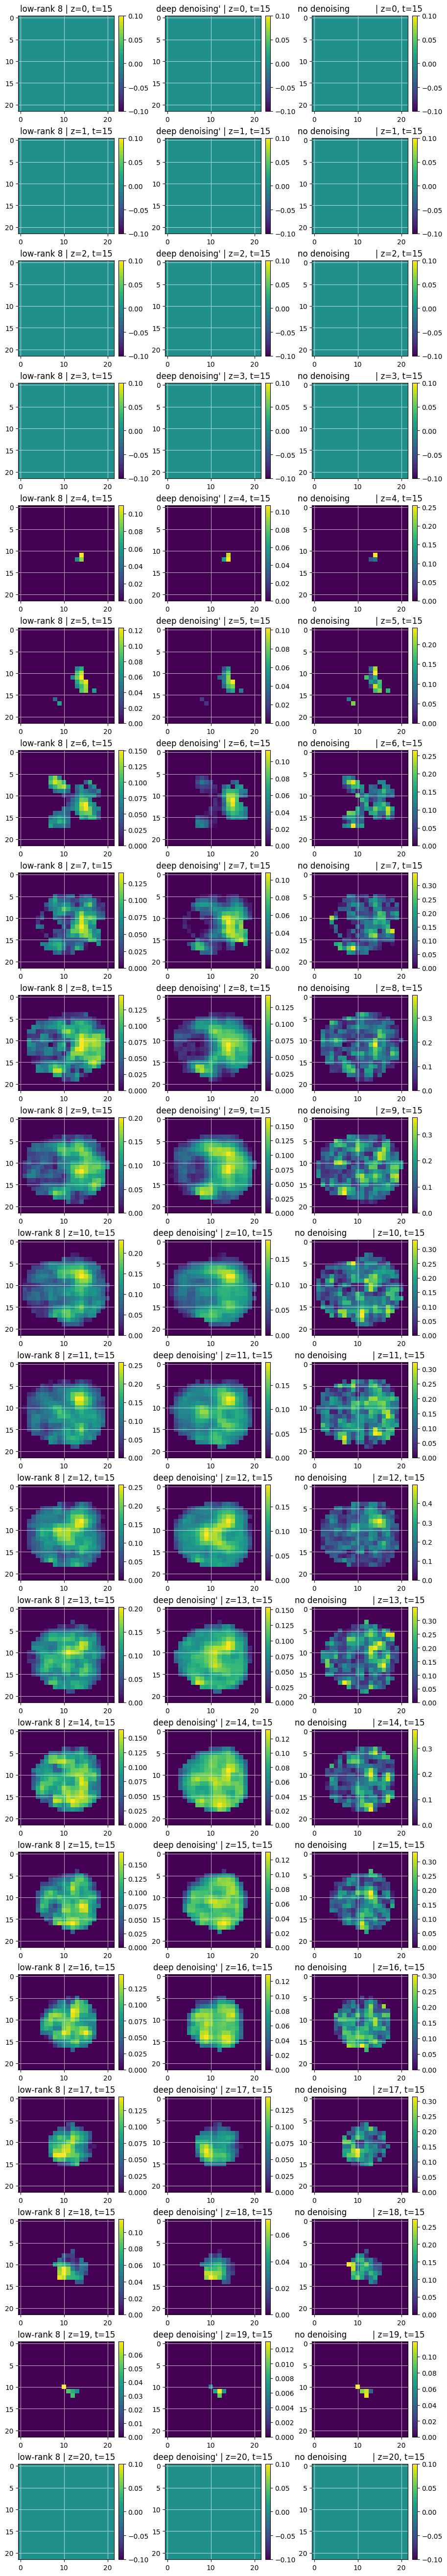

In [6]:
# ── Vergleich aller Z-Slices: Low-Rank | Deep Denoising | Input ─────────────

import numpy as np
import matplotlib.pyplot as plt

# 1) t- und T-Indizes einstellen
t, T = 15, 7

# 2) Anzahl der Z-Slices automatisch ermitteln
n_slices = out_data.shape[2]

# 3) Subplots erzeugen: n_slices Zeilen × 3 Spalten
fig, axes = plt.subplots(
    n_slices, 3,
    figsize=(9, n_slices * 2.5),
    constrained_layout=True
)

for i, z in enumerate(range(n_slices)):
    # 4) 2D-Slices extrahieren
    slice_lr   = np.abs(baseline_data[:, :, z, t, T])  # Low-Rank
    slice_deep = np.abs(out_data[:, :, z, t, T])       # Deep Denoised
    slice_in   = np.abs(tgt_data[:, :, z, t, T])       # Original Input

    # 5a) Low-Rank
    im0 = axes[i, 0].imshow(slice_lr,   cmap='viridis')
    axes[i, 0].set_title(f"low-rank {rank_post} | z={z}, t={t}")
    axes[i, 0].axis('on')
    axes[i, 0].grid(True, color='w', lw=0.5)  # weißes Grid
    plt.colorbar(im0, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # 5b) Deep Denoising
    im1 = axes[i, 1].imshow(slice_deep, cmap='viridis')
    axes[i, 1].set_title(f"deep denoising' | z={z}, t={t}")
    axes[i, 1].axis('on')
    axes[i, 1].grid(True, color='w', lw=0.5)  # weißes Grid
    plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # 5c) Input
    im2 = axes[i, 2].imshow(slice_in,   cmap='viridis')
    axes[i, 2].set_title(f"no denoising          | z={z}, t={t}")
    axes[i, 2].axis('on')
    axes[i, 2].grid(True, color='w', lw=0.5)  # weißes Grid

    plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

#plt.savefig("denoising_p2n.png", dpi=300)
plt.show()

# Compare spectra

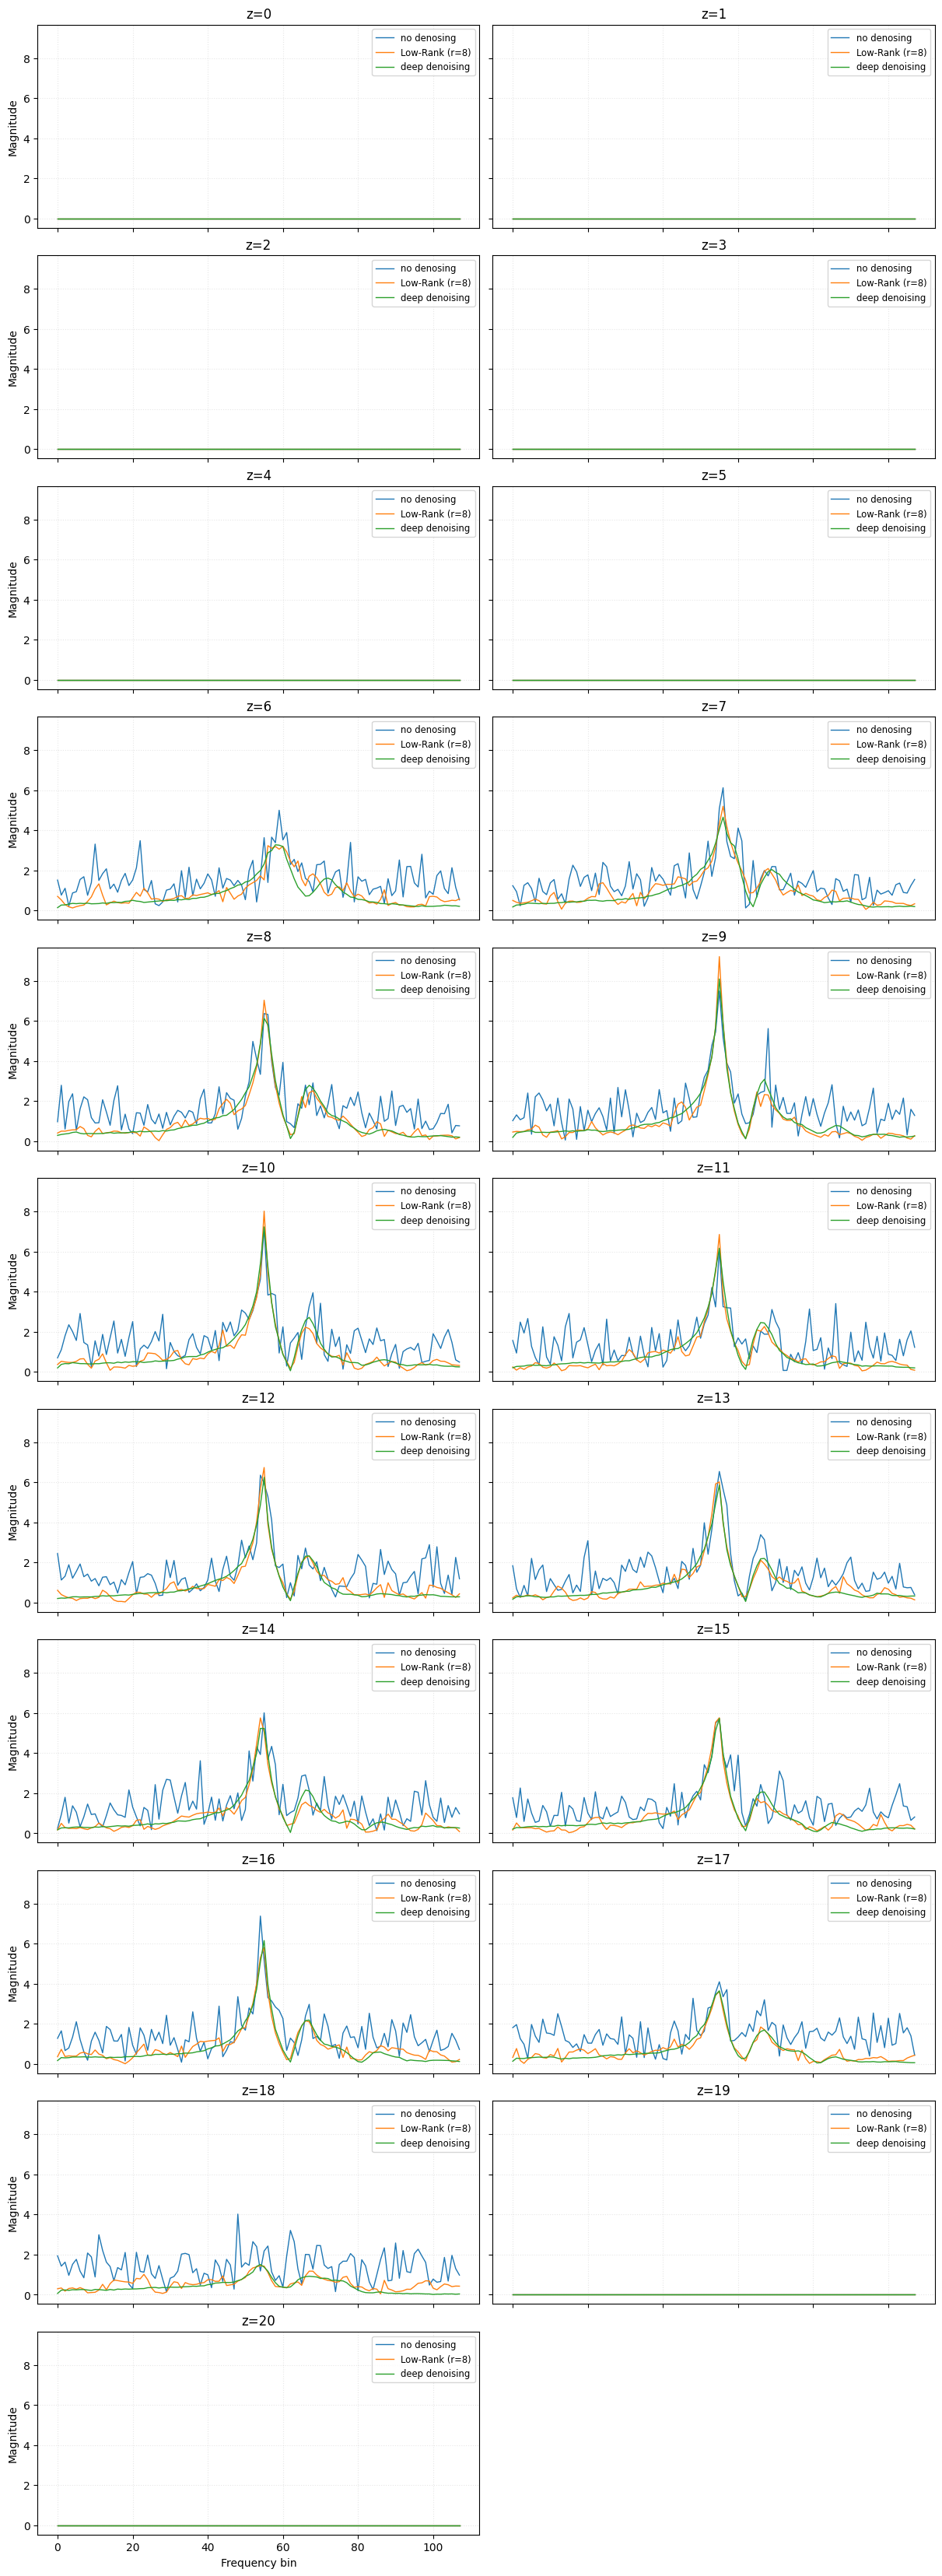

In [7]:
x,y,T = 8, 10, 9

# 2a) Deep-Denoising Spektrum
spec_deep = np.fft.fft(out_data, axis=3)
spec_deep = np.fft.fftshift(spec_deep, axes=3)

# 2b) Noisy Input Spektrum
spec_noisy = np.fft.fft(tgt_data, axis=3)
spec_noisy = np.fft.fftshift(spec_noisy, axes=3)

# 2c) Low-Rank Baseline Spektrum
spec_lr = np.fft.fft(baseline_data, axis=3)
spec_lr = np.fft.fftshift(spec_lr, axes=3)

# ── 21 Spektren für z=0…20 in einem 5×5-Grid plotten ─────────────────────────

# ── 21 Spektren (Noisy vs. Low-Rank vs. Noise2Void) in 2 Spalten ────────────

# ── 21 Spektren in 2 Spalten mit eigener Legende pro Plot und größerer Figure ──

import numpy as np
import matplotlib.pyplot as plt

# Parameter
#x, y, T = 10, 10, 7
Z       = spec_noisy.shape[2]   # Anzahl der z-Slices (hier 21)
F       = spec_noisy.shape[3]   # Anzahl der Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                     # Rang für Low-Rank

# Grid-Layout: 2 Spalten, genug Zeilen
n_cols  = 2
n_rows  = int(np.ceil(Z / n_cols))

# Figure größer machen: Breite × Höhe in Zoll
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 3),
    sharex=True, sharey=True,
    constrained_layout=True
)

for z in range(Z):
    i, j = divmod(z, n_cols)
    ax = axes[i, j]

    # Magnituden extrahieren
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])

    # Plots
    ax.plot(freqs, mag_noisy, '-',  label='no denosing', linewidth=1)
    ax.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank_post})', linewidth=1)
    ax.plot(freqs, mag_deep,  '-',  label=f'deep denoising', linewidth=1)

    ax.set_title(f"z={z}")
    ax.grid(True, linestyle=':', alpha=0.3)

    # Legende für jeden Subplot
    ax.legend(fontsize='small', loc='upper right')

    # Achsenbeschriftungen nur außen
    if i == n_rows - 1:
        ax.set_xlabel("Frequency bin")
    if j == 0:
        ax.set_ylabel("Magnitude")

# Leere Subplots ausblenden
for idx in range(Z, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

#plt.savefig("spectra.png", dpi=300)
plt.show()



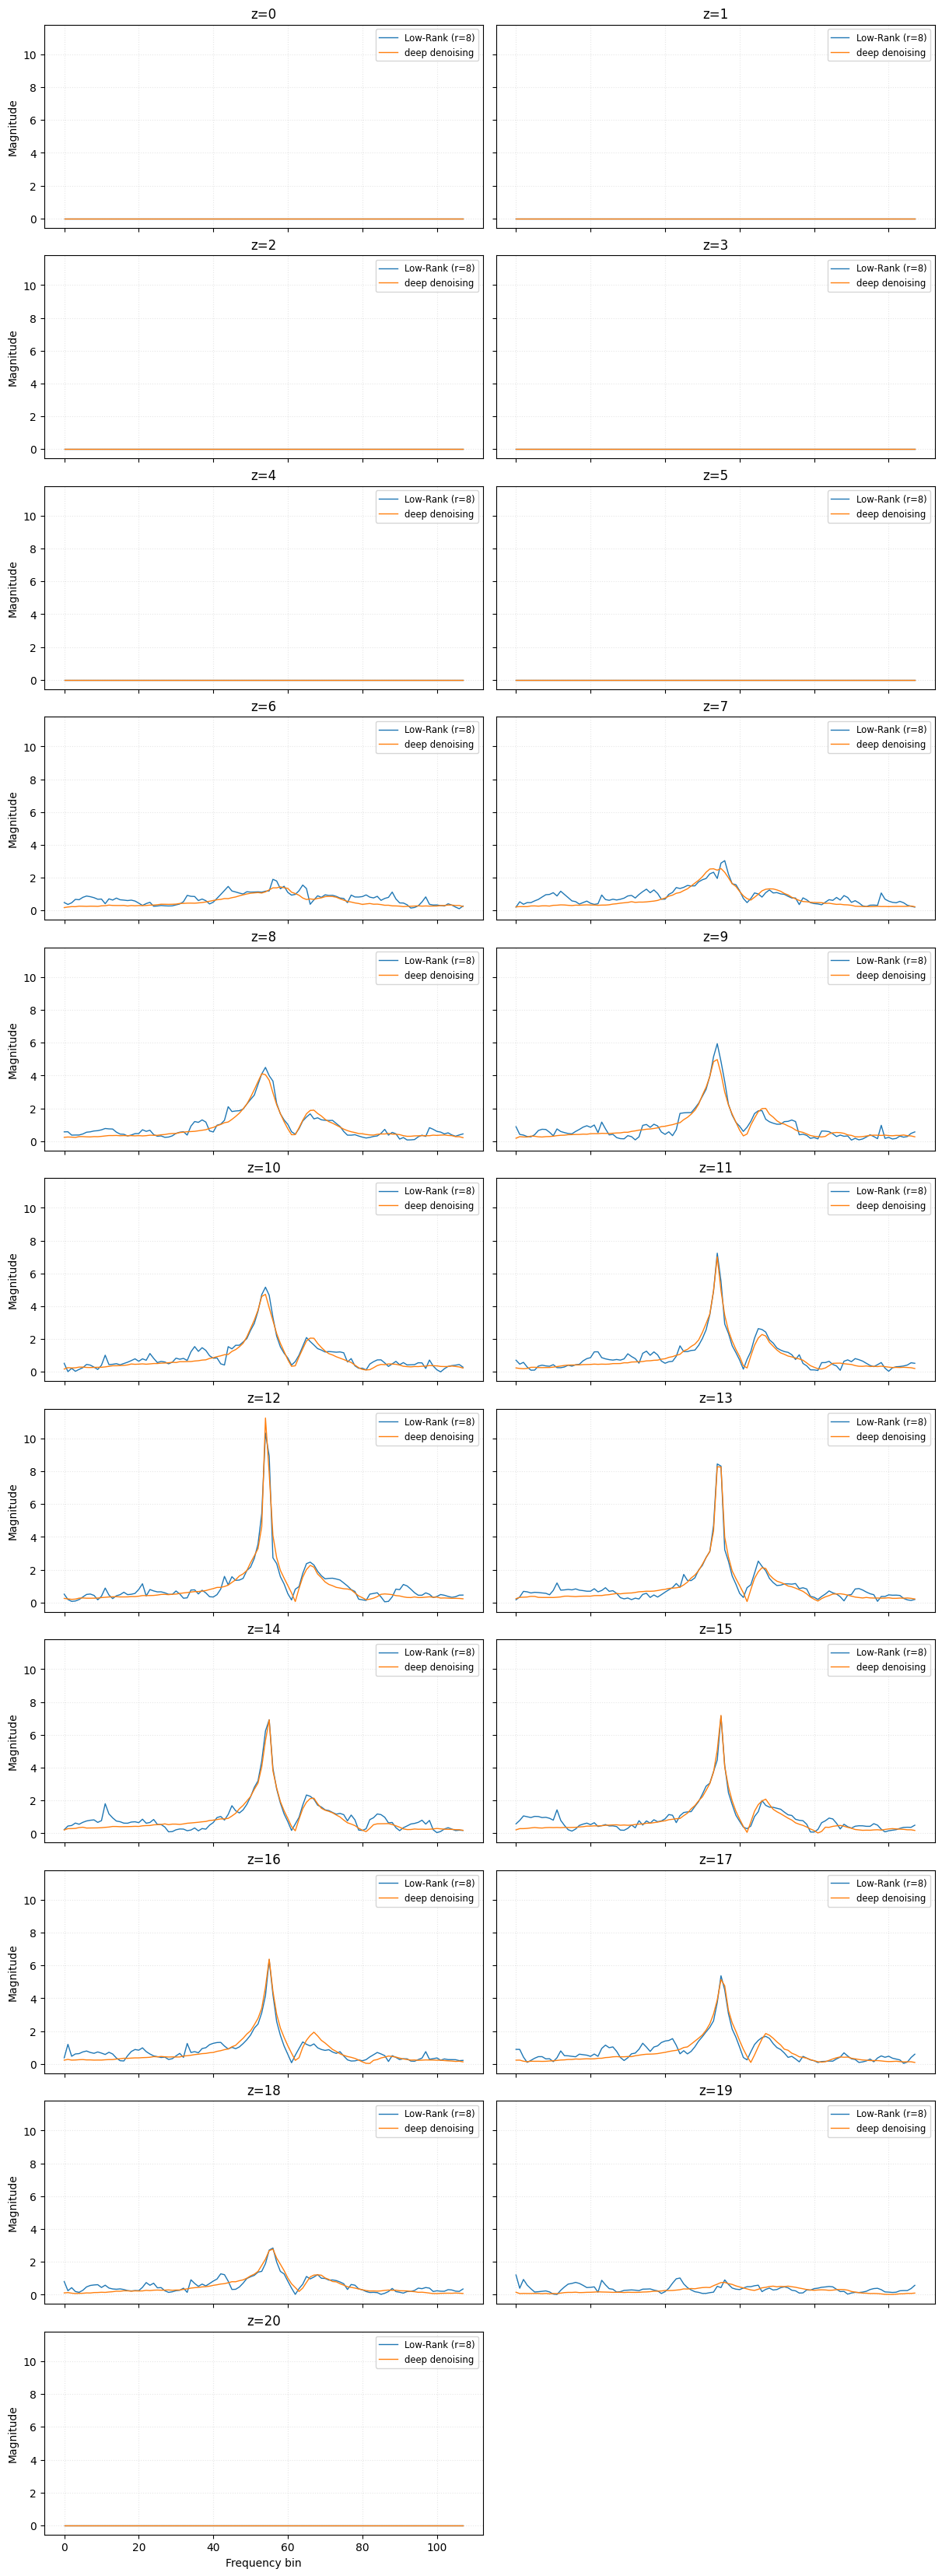

In [8]:
x,y,T = 10, 10, 0

# 2a) Deep-Denoising Spektrum
spec_deep = np.fft.fft(out_data, axis=3)
spec_deep = np.fft.fftshift(spec_deep, axes=3)

# 2b) Noisy Input Spektrum
spec_noisy = np.fft.fft(tgt_data, axis=3)
spec_noisy = np.fft.fftshift(spec_noisy, axes=3)

# 2c) Low-Rank Baseline Spektrum
spec_lr = np.fft.fft(baseline_data, axis=3)
spec_lr = np.fft.fftshift(spec_lr, axes=3)

# ── 21 Spektren für z=0…20 in einem 5×5-Grid plotten ─────────────────────────

# ── 21 Spektren (Noisy vs. Low-Rank vs. Noise2Void) in 2 Spalten ────────────

# ── 21 Spektren in 2 Spalten mit eigener Legende pro Plot und größerer Figure ──

import numpy as np
import matplotlib.pyplot as plt

# Parameter
x, y, T = 10, 10, 7
Z       = spec_noisy.shape[2]   # Anzahl der z-Slices (hier 21)
F       = spec_noisy.shape[3]   # Anzahl der Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                     # Rang für Low-Rank

# Grid-Layout: 2 Spalten, genug Zeilen
n_cols  = 2
n_rows  = int(np.ceil(Z / n_cols))

# Figure größer machen: Breite × Höhe in Zoll
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 3),
    sharex=True, sharey=True,
    constrained_layout=True
)

for z in range(Z):
    i, j = divmod(z, n_cols)
    ax = axes[i, j]

    # Magnituden extrahieren
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])

    # Plots
    ax.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank_post})', linewidth=1)
    ax.plot(freqs, mag_deep,  '-',  label=f'deep denoising', linewidth=1)

    ax.set_title(f"z={z}")
    ax.grid(True, linestyle=':', alpha=0.3)

    # Legende für jeden Subplot
    ax.legend(fontsize='small', loc='upper right')

    # Achsenbeschriftungen nur außen
    if i == n_rows - 1:
        ax.set_xlabel("Frequency bin")
    if j == 0:
        ax.set_ylabel("Magnitude")

# Leere Subplots ausblenden
for idx in range(Z, n_rows * n_cols):
    i, j = divmod(idx, n_cols)
    axes[i, j].axis('off')

#plt.savefig("spectra.png", dpi=300)
plt.show()

# Residuals to full dank noisy data

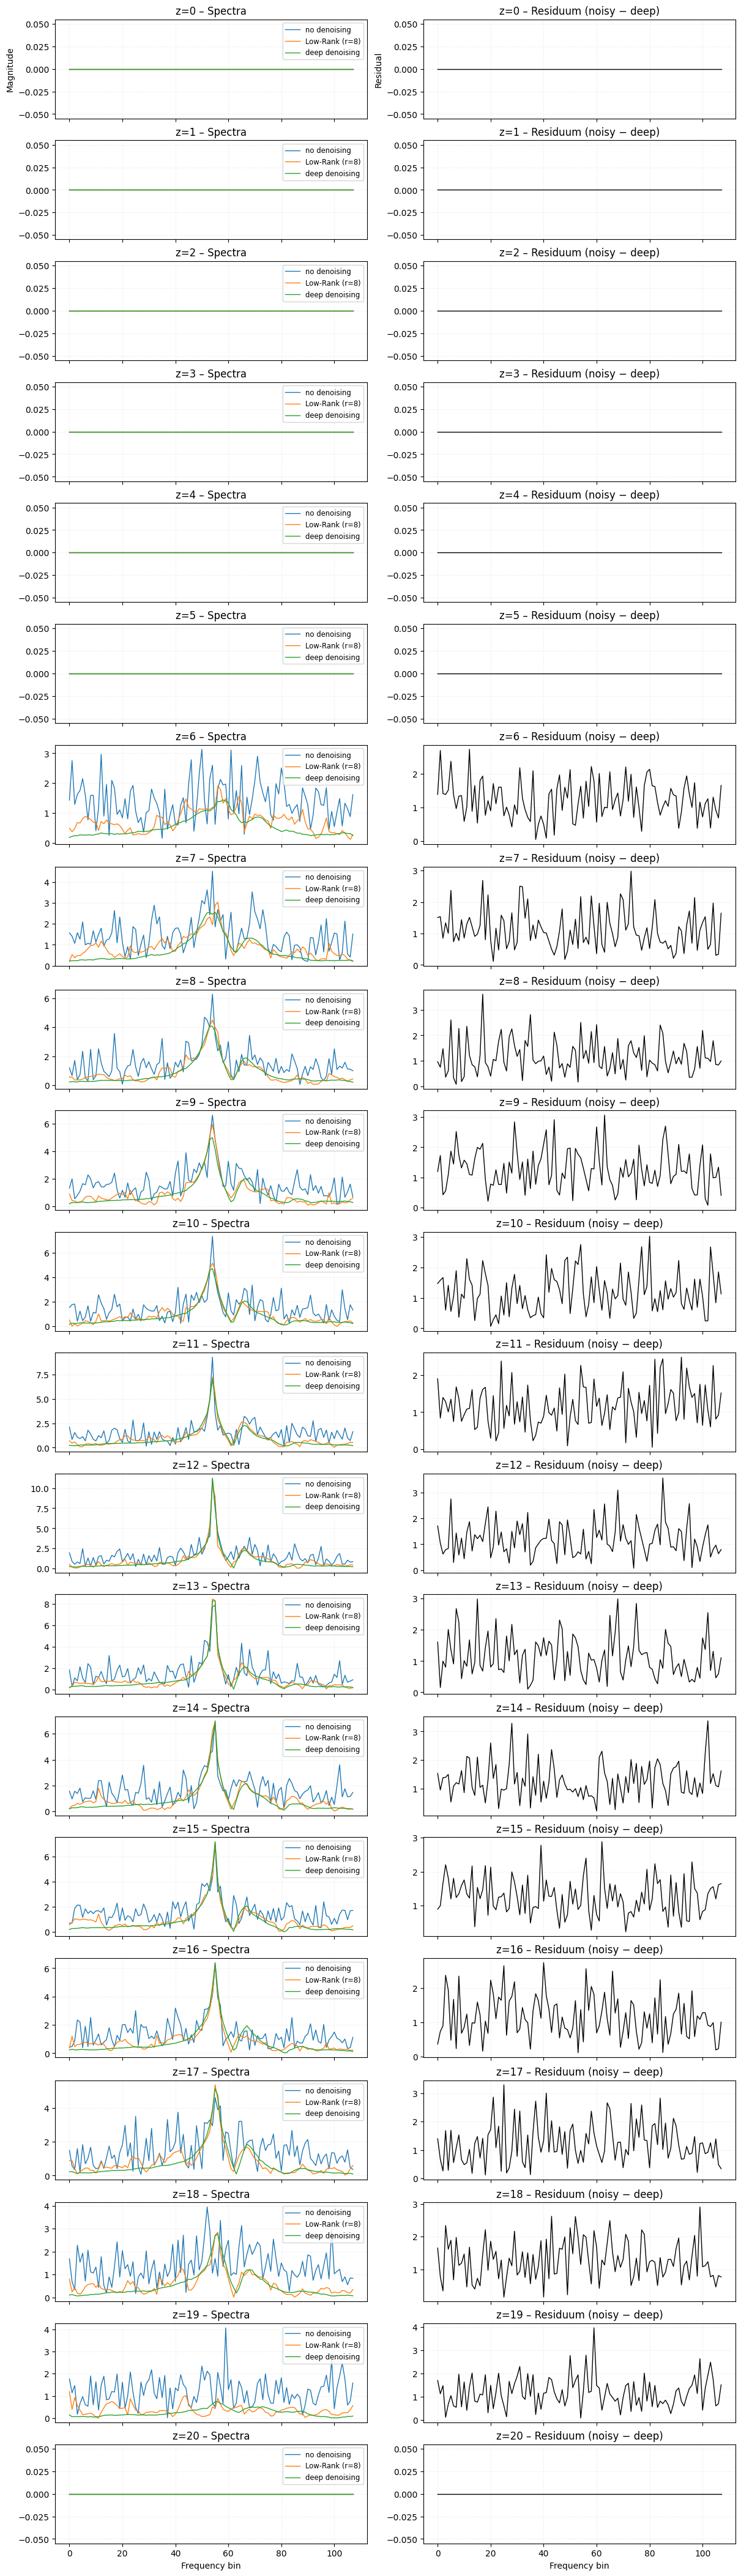

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
x, y, T = 10, 10, 7
Z       = spec_noisy.shape[2]   # Anzahl der z-Slices (z=0...20)
F       = spec_noisy.shape[3]   # Frequenz-Bins
freqs   = np.arange(F)
rank    = 8                     # Rang für Low-Rank

# Grid-Layout: 2 Spalten (Spektrum + Residuum), viele Zeilen
n_cols  = 2
n_rows  = Z

# Figure: größere Höhe, weil mehr Zeilen
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, n_rows * 2),
    sharex=True, constrained_layout=True
)

for z in range(Z):
    ax_spec = axes[z, 0]
    ax_res  = axes[z, 1]

    # Magnituden extrahieren
    mag_noisy = np.abs(spec_noisy[x, y, z, :, T])
    mag_lr    = np.abs(spec_lr   [x, y, z, :, T])
    mag_deep  = np.abs(spec_deep [x, y, z, :, T])
    resid     = np.abs(spec_noisy[x, y, z, :, T] - spec_deep [x, y, z, :, T])

    # Spektrenplot
    ax_spec.plot(freqs, mag_noisy, '-', label='no denoising', linewidth=1)
    ax_spec.plot(freqs, mag_lr,    '-', label=f'Low-Rank (r={rank})', linewidth=1)
    ax_spec.plot(freqs, mag_deep,  '-', label=f'deep denoising', linewidth=1)
    ax_spec.set_title(f"z={z} – Spectra")
    ax_spec.grid(True, linestyle=':', alpha=0.3)
    ax_spec.legend(fontsize='small', loc='upper right')

    # Residuenplot
    ax_res.plot(freqs, resid, '-', color='black', linewidth=1)
    ax_res.set_title(f"z={z} – Residuum (noisy − deep)")
    ax_res.grid(True, linestyle=':', alpha=0.3)

    # Achsenbeschriftungen
    if z == n_rows - 1:
        ax_spec.set_xlabel("Frequency bin")
        ax_res.set_xlabel("Frequency bin")
    if z == 0:
        ax_spec.set_ylabel("Magnitude")
        ax_res.set_ylabel("Residual")

#plt.savefig("spectra_and_residuals.png", dpi=300)
plt.show()

In [10]:
import numpy as np

# Residuum komplex, ohne Abs:
resid = spec_noisy - spec_deep  # Shape (x, y, Z, F, T)
# Wir flatten über alle z und Frequenzen (nur ein T):
r = resid[x, y, z, :, :].ravel()

# Power Spectral Density
psd = np.abs(r)**2 + 1e-12  # Epsilon gegen log(0)

# Spectral flatness
flatness = np.exp(np.mean(np.log(psd))) / np.mean(psd)
print(f"Spectral flatness: {flatness:.3f}")
# Werte in der Nähe von 1 sprechen für weißes Rauschen.


Spectral flatness: 1.000


In [11]:
from scipy.stats import normaltest

# Real‑Teil testen
stat, pval = normaltest(np.real(r))
print(f"D’Agostino’s K² – stat={stat:.2f}, p={pval:.3f}")
if pval > 0.05:
    print("Kann Normalverteilung nicht verwerfen → passt zu Rauschen")
else:
    print("Signifikante Abweichung von Normalität → evtl. Struktur")

D’Agostino’s K² – stat=nan, p=nan
Signifikante Abweichung von Normalität → evtl. Struktur


In [12]:
tgt_data.shape

(22, 22, 21, 108, 10)

# Compare spectral peaks

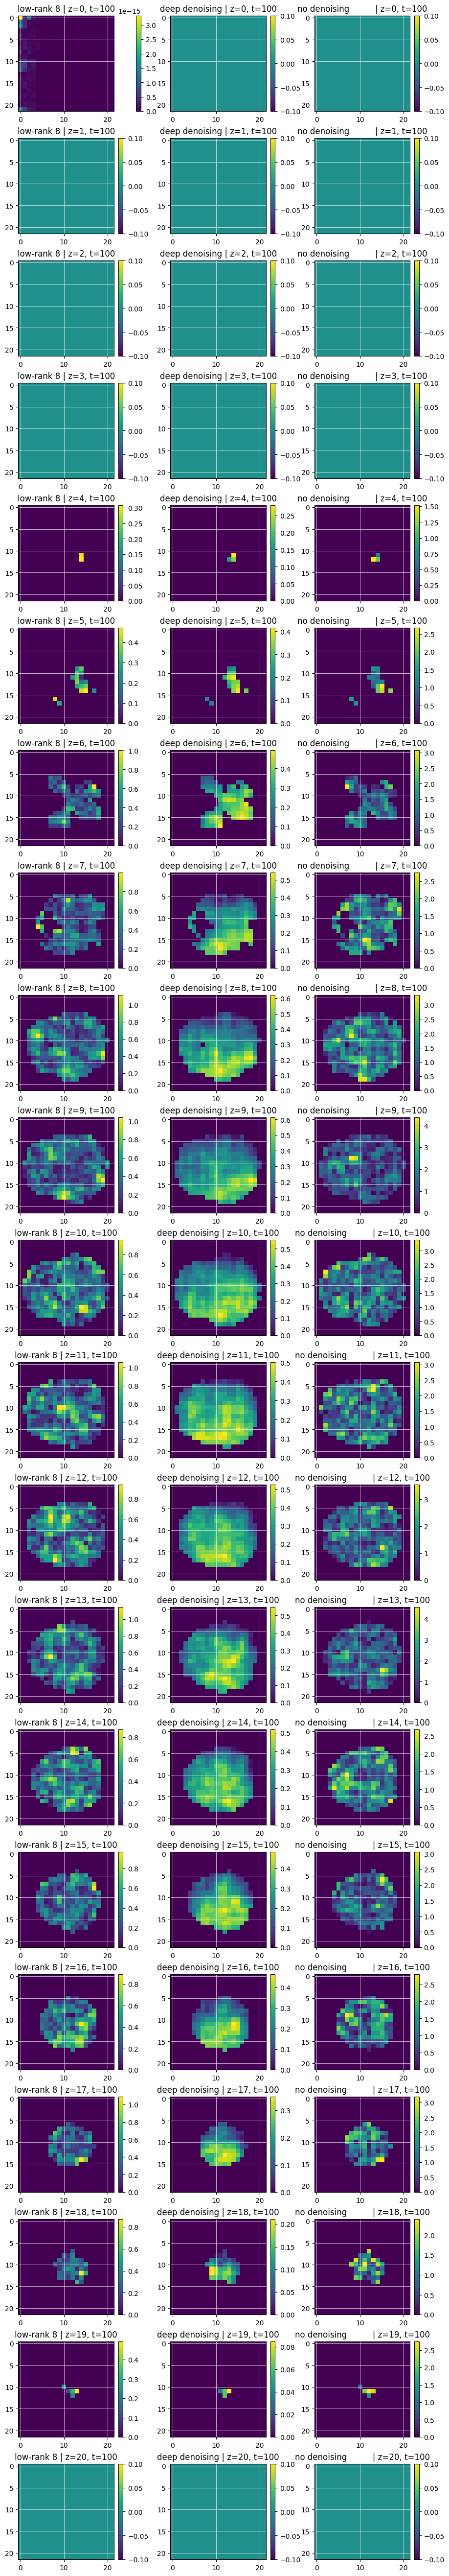

In [13]:
# ── Vergleich aller Z-Slices: Low-Rank | Deep Denoising | Input ─────────────

import numpy as np
import matplotlib.pyplot as plt

# 1) t- und T-Indizes einstellen
t, T = 100, 9  # 85~Glx

# 2) Anzahl der Z-Slices automatisch ermitteln
n_slices = out_data.shape[2]

# 3) Subplots erzeugen: n_slices Zeilen × 3 Spalten
fig, axes = plt.subplots(
    n_slices, 3,
    figsize=(9, n_slices * 2.5),
    constrained_layout=True
)

for i, z in enumerate(range(n_slices)):
    # 4) 2D-Slices extrahieren
    slice_lr   = np.abs(baseline_data_ft[:, :, z, t, T])  # Low-Rank
    slice_deep = np.abs(out_data_ft[:, :, z, t, T])       # Deep Denoised
    slice_in   = np.abs(tgt_data_ft[:, :, z, t, T])       # Original Input

    # 5a) Low-Rank
    im0 = axes[i, 0].imshow(slice_lr,   cmap='viridis')
    axes[i, 0].set_title(f"low-rank {rank_post} | z={z}, t={t}")
    #axes[i, 0].axis('off')
    axes[i, 0].axis('on')
    axes[i, 0].grid(True, color='w', lw=0.5)  # weißes Grid
    plt.colorbar(im0, ax=axes[i, 0], fraction=0.046, pad=0.04)

    # 5b) Deep Denoising
    im1 = axes[i, 1].imshow(slice_deep, cmap='viridis')
    axes[i, 1].set_title(f"deep denoising | z={z}, t={t}")
    #axes[i, 1].axis('off')
    axes[i, 1].axis('on')
    axes[i, 1].grid(True, color='w', lw=0.5)  # weißes Grid
    plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

    # 5c) Input
    im2 = axes[i, 2].imshow(slice_in,   cmap='viridis')
    axes[i, 2].set_title(f"no denoising          | z={z}, t={t}")
    #axes[i, 2].axis('off')
    axes[i, 2].axis('on')
    axes[i, 2].grid(True, color='w', lw=0.5)  # weißes Grid
    plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

#plt.savefig("denoising_p2n.png", dpi=300)
plt.show()

# Compare average spectra
Here I compare the average spectrum over time (which is a high SNR estimate) for gey matter which matter and all matter

In [14]:
avg_out = np.mean(out_data_ft, axis=(0, 1, 2))

avg_lr = np.mean(baseline_data_ft, axis=(0, 1, 2))

avg_tgt = np.mean(tgt_data_ft, axis=(0, 1, 2))

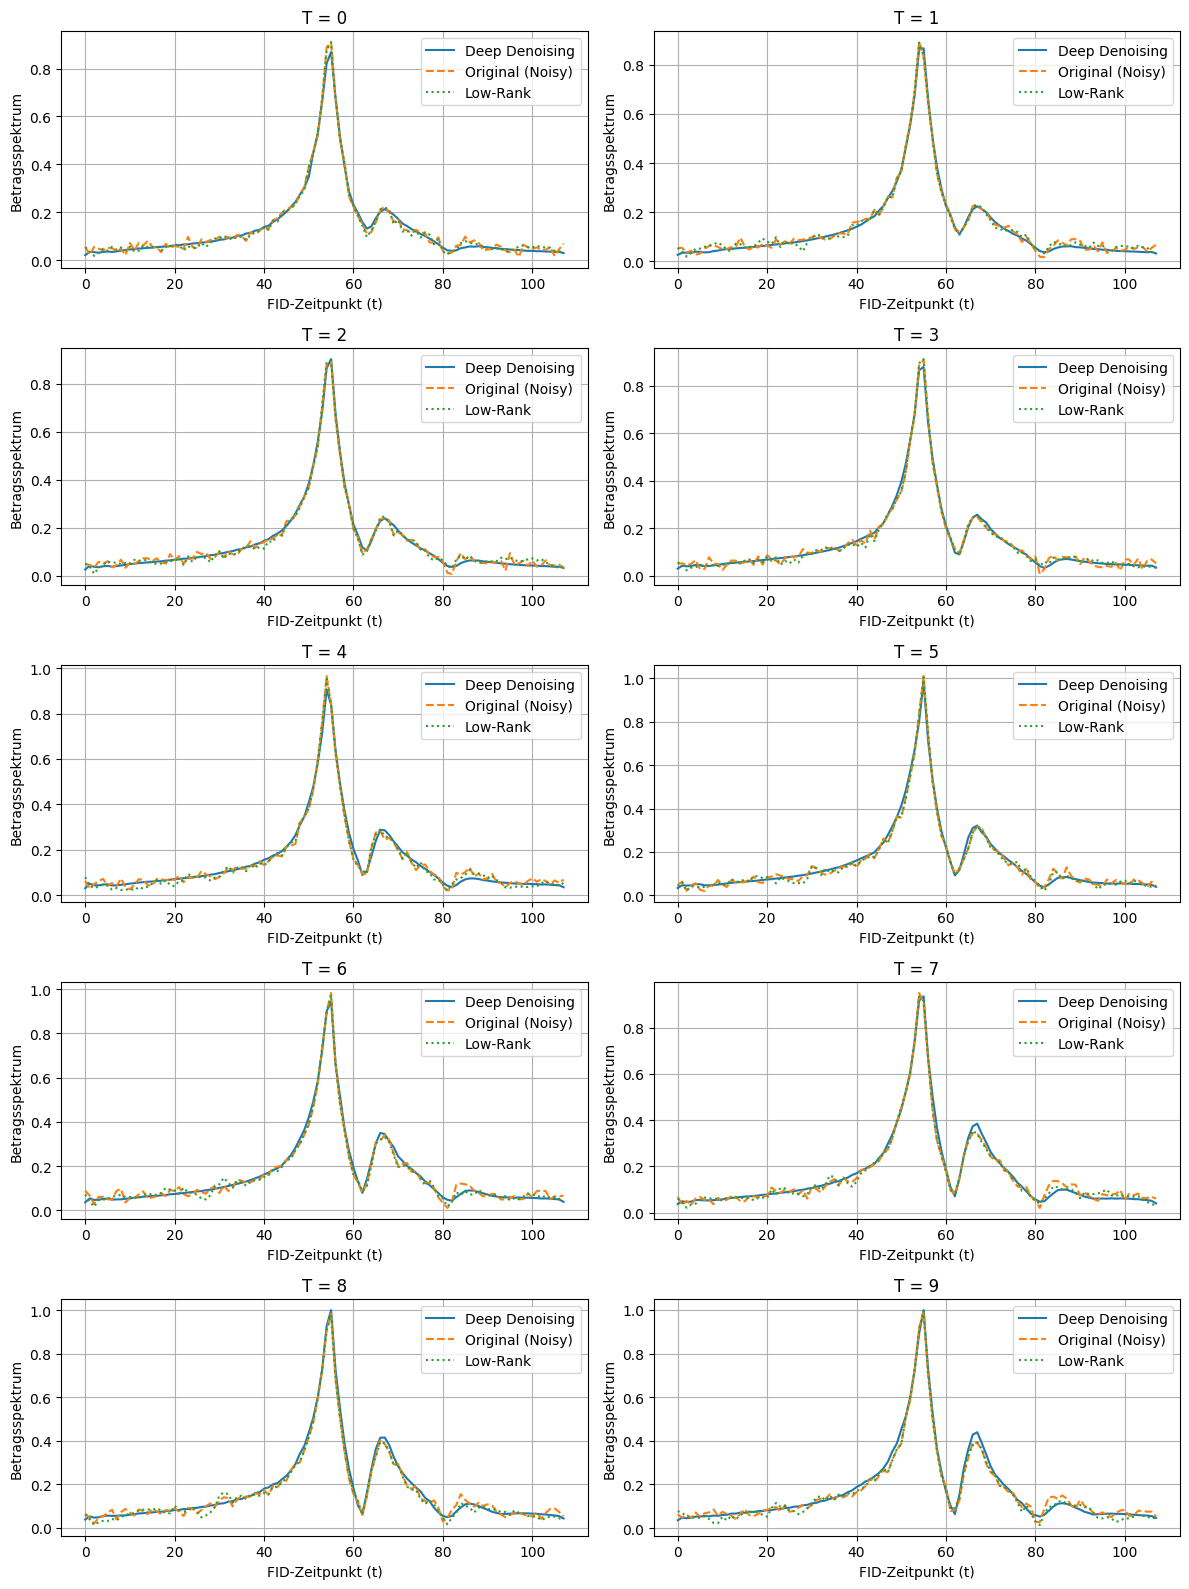

In [15]:
import matplotlib.pyplot as plt

# Subplot-Grid: 4 Zeilen × 2 Spalten für T = 0 bis 7
num_rows, num_cols = 5, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

for idx, T in enumerate(range(10)):
    i = idx // num_cols
    j = idx % num_cols
    ax = axes[i, j]
    
    # Spektren extrahieren
    Line   = np.abs(avg_out)[:, T]
    Line_2 = np.abs(avg_tgt)[:, T]
    Line_3 = np.abs(avg_lr)[:, T]
    
    ax.plot(Line,   label="Deep Denoising")
    ax.plot(Line_2, linestyle="--", label="Original (Noisy)")
    ax.plot(Line_3, linestyle=":",  label="Low-Rank")
    
    ax.set_xlabel("FID-Zeitpunkt (t)")
    ax.set_ylabel("Betragsspektrum")
    ax.set_title(f"T = {T}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


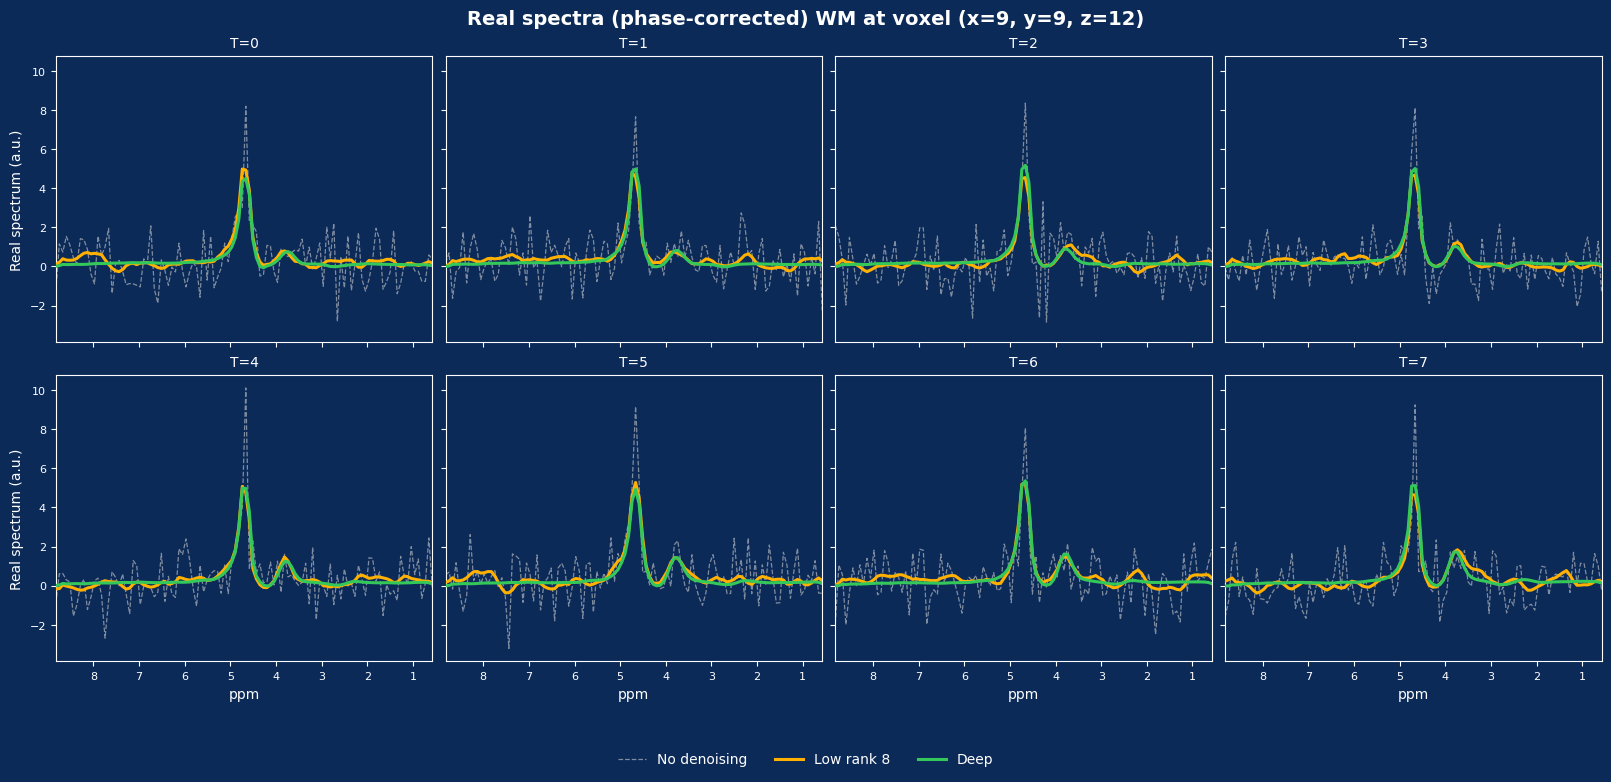

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ======================== Einstellungen ========================
# Voxel wählen
x, y, z = 9, 9, 12

# Low-rank Rang (nur für Label)
rank = 8

# Peak-Fenster (in Frequenz-Bins) für die Vorzeichen-/Phasenausrichtung
peak_win = (40, 55)

# Farben & Style
col_lr   = "#ffb000"   # warmes Orange
col_deep = "#34c759"   # Grün
col_nois = "#cfcfcf"   # hellgrau
bg = "#0b2a58"         # dunkles Blau

# leichtes Glätten
def smooth(x, k: int = 3):
    if k <= 1: return x
    k = max(1, int(k))
    w = np.ones(k) / k
    return np.convolve(x, w, mode="same")
smooth_k = 3

# ======================== Phasenkorrektur ========================
def phase_zero_on_window(s, win):
    a = np.sum(s[win[0]:win[1]])
    phi0 = -np.angle(a)
    return phi0

def phase_first_on_window(s, phi0, f, win, phi1_max=np.deg2rad(15), n=101):
    s0 = s * np.exp(-1j*phi0)
    grid = np.linspace(-phi1_max, +phi1_max, n)
    slc = slice(win[0], win[1])
    best = 0.0; best_val = np.inf
    for p1 in grid:
        sc = s0 * np.exp(-1j*(2*np.pi)*p1*f)
        val = np.sum(np.imag(sc[slc])**2)
        if val < best_val:
            best_val = val; best = p1
    return best

def apply_phase_01(s, phi0, phi1, f):
    return s * np.exp(-1j*(phi0 + (2*np.pi)*phi1*f))

def enforce_sign_on_window(sr, win, sign=+1):
    ssum = np.sum(sr[win[0]:win[1]])
    if np.sign(np.real(ssum)) != sign:
        sr = -sr
    return sr

# ======================== Frequenz- & ppm-Achse ========================
F     = spec_noisy.shape[3]
f     = (np.arange(F) - (F-1)/2) / F   # normiert zu fftshift

# Scanner-/Sequenzparameter (²H)
dwell    = 2.6316e-3     # Sekunden (2.6316 ms)
f_ref_Hz = 45_625_549    # Larmorfrequenz in Hz
ref_ppm  = 4.7           # Referenz (Wasser) in ppm

SW       = 1.0 / dwell   # ~380 Hz
bins_c   = np.arange(F) - (F-1)/2
hz_axis  = bins_c * (SW / F)
ppm_axis = ref_ppm - (hz_axis / f_ref_Hz * 1e6)  # ppm-Achse

# ======================== Phasenschätzung ========================
s_ref = np.mean(spec_noisy[x, y, z, :, :], axis=-1)
phi0 = phase_zero_on_window(s_ref, peak_win)
phi1 = phase_first_on_window(s_ref, phi0, f, peak_win, phi1_max=np.deg2rad(15), n=101)

# ======================== Plot ========================
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16,7),
                         sharex=True, sharey=True,
                         constrained_layout=True, facecolor=bg)

for T in range(8):
    i, j = divmod(T, 4)
    ax = axes[i, j]
    ax.set_facecolor(bg)

    sN = apply_phase_01(spec_noisy[x,y,z,:,T], phi0, phi1, f)
    sL = apply_phase_01(spec_lr   [x,y,z,:,T], phi0, phi1, f)
    sD = apply_phase_01(spec_deep [x,y,z,:,T], phi0, phi1, f)

    rN = enforce_sign_on_window(np.real(sN), (peak_win[0], peak_win[1]), sign=+1)
    rL = enforce_sign_on_window(np.real(sL), (peak_win[0], peak_win[1]), sign=+1)
    rD = enforce_sign_on_window(np.real(sD), (peak_win[0], peak_win[1]), sign=+1)

    rL = smooth(rL, smooth_k)
    rD = smooth(rD, smooth_k)

    ax.plot(ppm_axis, rN, linestyle="--", color=col_nois, linewidth=0.9,
            alpha=0.6, zorder=1, label="No denoising")
    ax.plot(ppm_axis, rL, color=col_lr, linewidth=2.2, zorder=3,
            label=f"Low rank 8")
    ax.plot(ppm_axis, rD, color=col_deep, linewidth=2.2, zorder=4,
            label="Deep")

    ax.set_title(f"T={T}", color="white", fontsize=10)
    ax.grid(False)
    ax.tick_params(colors="white", labelsize=8)
    for sp in ax.spines.values():
        sp.set_color("white")
    if i == n_rows-1: ax.set_xlabel("ppm", color="white")
    if j == 0:        ax.set_ylabel("Real spectrum (a.u.)", color="white")

# gemeinsame Legende unterhalb der Subplots
h, l = axes[0,0].get_legend_handles_labels()
leg = fig.legend(h, l,
                 loc="upper center",
                 bbox_to_anchor=(0.5, -0.05),
                 ncol=3, fontsize=10, frameon=False)
for t in leg.get_texts():
    t.set_color("white")

# ppm-Konvention: links hoch → rechts niedrig
for ax in axes.ravel():
    ax.set_xlim(ppm_axis.max(), ppm_axis.min())

fig.suptitle(f"Real spectra (phase-corrected) WM at voxel (x={x}, y={y}, z={z})",
             fontsize=14, fontweight="bold", color="white")

# ========= PDF speichern =========
plt.savefig("spectra_phase_corrected_WM.pdf", dpi=300,
            bbox_inches="tight", facecolor=fig.get_facecolor())

plt.show()



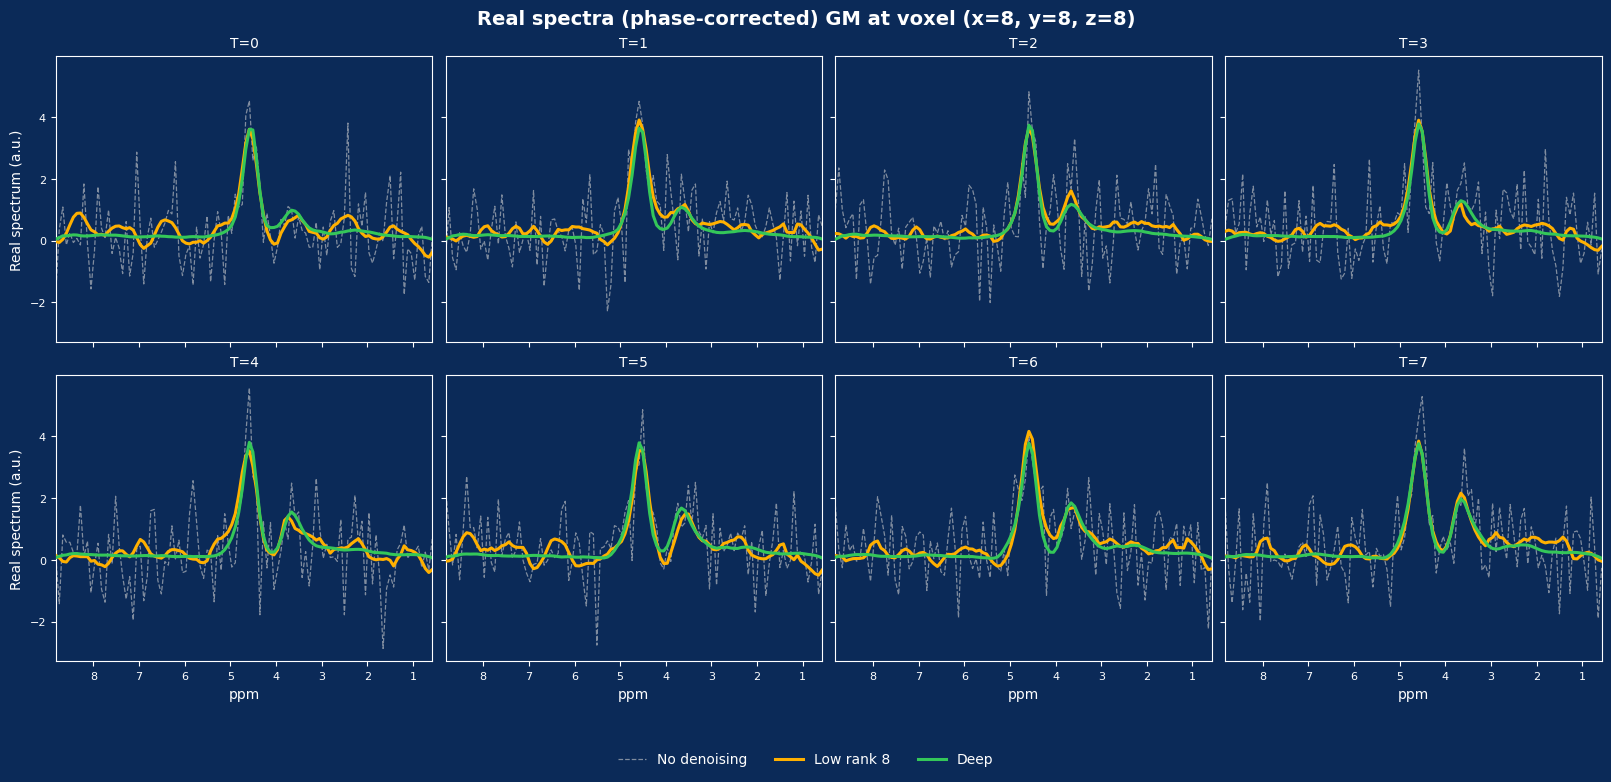

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ======================== Einstellungen ========================
# Voxel wählen
x, y, z = 8, 8, 8

# Low-rank Rang (nur für Label)
rank = 8

# Peak-Fenster (in Frequenz-Bins) für die Vorzeichen-/Phasenausrichtung
peak_win = (40, 55)

# Farben & Style
col_lr   = "#ffb000"   # warmes Orange
col_deep = "#34c759"   # Grün
col_nois = "#cfcfcf"   # hellgrau
bg = "#0b2a58"         # dunkles Blau

# leichtes Glätten
def smooth(x, k: int = 3):
    if k <= 1: return x
    k = max(1, int(k))
    w = np.ones(k) / k
    return np.convolve(x, w, mode="same")
smooth_k = 3

# ======================== Phasenkorrektur ========================
def phase_zero_on_window(s, win):
    a = np.sum(s[win[0]:win[1]])
    phi0 = -np.angle(a)
    return phi0

def phase_first_on_window(s, phi0, f, win, phi1_max=np.deg2rad(15), n=101):
    s0 = s * np.exp(-1j*phi0)
    grid = np.linspace(-phi1_max, +phi1_max, n)
    slc = slice(win[0], win[1])
    best = 0.0; best_val = np.inf
    for p1 in grid:
        sc = s0 * np.exp(-1j*(2*np.pi)*p1*f)
        val = np.sum(np.imag(sc[slc])**2)
        if val < best_val:
            best_val = val; best = p1
    return best

def apply_phase_01(s, phi0, phi1, f):
    return s * np.exp(-1j*(phi0 + (2*np.pi)*phi1*f))

def enforce_sign_on_window(sr, win, sign=+1):
    ssum = np.sum(sr[win[0]:win[1]])
    if np.sign(np.real(ssum)) != sign:
        sr = -sr
    return sr

# ======================== Frequenz- & ppm-Achse ========================
F     = spec_noisy.shape[3]
f     = (np.arange(F) - (F-1)/2) / F   # normiert zu fftshift

# Scanner-/Sequenzparameter (²H)
dwell    = 2.6316e-3     # Sekunden (2.6316 ms)
f_ref_Hz = 45_625_549    # Larmorfrequenz in Hz
ref_ppm  = 4.7           # Referenz (Wasser) in ppm

SW       = 1.0 / dwell   # ~380 Hz
bins_c   = np.arange(F) - (F-1)/2
hz_axis  = bins_c * (SW / F)
ppm_axis = ref_ppm - (hz_axis / f_ref_Hz * 1e6)  # ppm-Achse

# ======================== Phasenschätzung ========================
s_ref = np.mean(spec_noisy[x, y, z, :, :], axis=-1)
phi0 = phase_zero_on_window(s_ref, peak_win)
phi1 = phase_first_on_window(s_ref, phi0, f, peak_win, phi1_max=np.deg2rad(15), n=101)

# ======================== Plot ========================
n_rows, n_cols = 2, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16,7),
                         sharex=True, sharey=True,
                         constrained_layout=True, facecolor=bg)

for T in range(8):
    i, j = divmod(T, 4)
    ax = axes[i, j]
    ax.set_facecolor(bg)

    sN = apply_phase_01(spec_noisy[x,y,z,:,T], phi0, phi1, f)
    sL = apply_phase_01(spec_lr   [x,y,z,:,T], phi0, phi1, f)
    sD = apply_phase_01(spec_deep [x,y,z,:,T], phi0, phi1, f)

    rN = enforce_sign_on_window(np.real(sN), (peak_win[0], peak_win[1]), sign=+1)
    rL = enforce_sign_on_window(np.real(sL), (peak_win[0], peak_win[1]), sign=+1)
    rD = enforce_sign_on_window(np.real(sD), (peak_win[0], peak_win[1]), sign=+1)

    rL = smooth(rL, smooth_k)
    rD = smooth(rD, smooth_k)

    ax.plot(ppm_axis, rN, linestyle="--", color=col_nois, linewidth=0.9,
            alpha=0.6, zorder=1, label="No denoising")
    ax.plot(ppm_axis, rL, color=col_lr, linewidth=2.2, zorder=3,
            label=f"Low rank 8")
    ax.plot(ppm_axis, rD, color=col_deep, linewidth=2.2, zorder=4,
            label="Deep")

    ax.set_title(f"T={T}", color="white", fontsize=10)
    ax.grid(False)
    ax.tick_params(colors="white", labelsize=8)
    for sp in ax.spines.values():
        sp.set_color("white")
    if i == n_rows-1: ax.set_xlabel("ppm", color="white")
    if j == 0:        ax.set_ylabel("Real spectrum (a.u.)", color="white")

# gemeinsame Legende unterhalb der Subplots
h, l = axes[0,0].get_legend_handles_labels()
leg = fig.legend(h, l,
                 loc="upper center",
                 bbox_to_anchor=(0.5, -0.05),
                 ncol=3, fontsize=10, frameon=False)
for t in leg.get_texts():
    t.set_color("white")

# ppm-Konvention: links hoch → rechts niedrig
for ax in axes.ravel():
    ax.set_xlim(ppm_axis.max(), ppm_axis.min())

fig.suptitle(f"Real spectra (phase-corrected) GM at voxel (x={x}, y={y}, z={z})",
             fontsize=14, fontweight="bold", color="white")

# ========= PDF speichern =========
plt.savefig("spectra_phase_corrected_GM.pdf", dpi=300,
            bbox_inches="tight", facecolor=fig.get_facecolor())

plt.show()